# Preamble

Let's set up the environment first. We need the coingecko API to fetch prices, and pandas to work with timeseries (and tabular data in general).

In [1]:
from pycoingecko import CoinGeckoAPI
gecko = CoinGeckoAPI()

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
import datetime as dt

In [5]:
import requests

In [6]:
from time import sleep

In [7]:
from IPython.display import clear_output

# Experiments

First, let's set up the correct URL and parsing and all that jazz.

In [8]:
def __get_historical_data_url(coin_id, currency_id, start_date, end_date):
    return 'https://www.coingecko.com/en/coins/{}/historical_data/{}?end_date={}&start_date={}'.format(coin_id, currency_id, end_date.isoformat(), start_date.isoformat()) 

In [9]:
def get_historical_data_scraper(coin_id, currency_id, start_date_s, end_date_s):
    start_date = dt.date.fromisoformat(start_date_s)
    end_date = dt.date.fromisoformat(end_date_s)

    url = __get_historical_data_url(coin_id, currency_id, start_date, end_date)
    r = requests.get(url, timeout=5, stream=True)
    
    try:
        dfs = pd.read_html(r.content, parse_dates=['Date'])
    except:
        return None
    if len(dfs) != 1:
        return None

    df = dfs[0][::-1].set_index("Date")
    df = df.replace({'[$,]': ''}, regex=True).apply(pd.to_numeric)
    df.columns = pd.MultiIndex.from_product([[coin_id], df.columns])

    return df

In [10]:
def get_historical_data_gecko(coin_id, currency_id, start_date_s, end_date_s):
    p = gecko.get_coin_market_chart_range_by_id(coin_id, currency_id, dt.datetime.fromisoformat(start_date_s).strftime("%s"), dt.datetime.fromisoformat(end_date_s).strftime("%s"))

    df_mcaps = pd.DataFrame(p['market_caps'], columns=['Date', 'Market Cap'])
    df_mcaps['Date'] = pd.to_datetime(df_mcaps['Date'].apply(lambda x: dt.datetime.utcfromtimestamp(x/1000).date()))
    df_mcaps.set_index("Date", inplace=True)

    df_vol = pd.DataFrame(p['total_volumes'], columns=['Date', 'Volume'])
    df_vol['Date'] = pd.to_datetime(df_vol['Date'].apply(lambda x: dt.datetime.utcfromtimestamp(x/1000).date()))
    df_vol.set_index("Date", inplace=True)

    df_prices = pd.DataFrame(p['prices'], columns=['Date', 'Open'])
    df_prices['Date'] = pd.to_datetime(df_prices['Date'].apply(lambda x: dt.datetime.utcfromtimestamp(x/1000).date()))
    df_prices.set_index("Date", inplace=True)

    df = pd.concat([df_mcaps, df_vol, df_prices], axis=1)
    df['Close'] = df['Open'].shift(-1)

    df.columns = pd.MultiIndex.from_product([[coin_id], df.columns])

    return df

In [11]:
def get_historical_data(coin_id, currency_id, start_date_s, end_date_s):
    df = None
    try:
        df = get_historical_data_gecko(coin_id, currency_id, start_date_s, end_date_s)
    except:
        try:
            df = get_historical_data_scraper(coin_id, currency_id, start_date_s, end_date_s)
        except:
            return None
    return df

Let's test the functions.

In [12]:
df = get_historical_data('bitcoin', 'usd', '2013-01-01', '2021-04-01')
df.head()

bitcoin                       
              Market Cap Volume    Open   Close
Date                                           
2013-04-28  1.500518e+09    0.0  135.30  141.96
2013-04-29  1.575032e+09    0.0  141.96  135.30
2013-04-30  1.501657e+09    0.0  135.30  117.00
2013-05-01  1.298952e+09    0.0  117.00  103.43
2013-05-02  1.148668e+09    0.0  103.43   91.01

In [13]:
coins_list = pd.DataFrame(gecko.get_coins_list())

# Download it all

Finally, let's download the daily data for all tokens, across all time.

In [21]:
coins_list_ids = coins_list['id']
coins_list_ids_len = len(coins_list_ids)

dfs = []
i = 0
timeout = 1
while i < coins_list_ids_len: 
    coin = coins_list_ids[i]
    
    df = get_historical_data(coin, 'usd', '2013-01-01', '2021-04-01')
    if df is None:
        print ("Failed to download", coin)
        sleep(timeout)
        continue
    
    i = i + 1
    dfs.append(df)

    clear_output(wait=True)
    print ("Downloaded", coin, "{}/{}".format(i, coins_list_ids_len - 1))

Downloaded zzz-finance-v2 6548/6547


Now, concatenate the entire list of dataframes.

In [31]:
from collections import deque

def binary_reduce(I, f):
    Q = deque(I)
    Q.appendleft(None)
    Q_len = len(Q)

    while len(Q) > 2:
        clear_output(wait=True)
        print ("Size {}/{}".format(len(Q), Q_len))
        
        a = Q.pop()
        if a is None:
            Q.appendleft(None)
            continue

        b = Q.pop()
        if b is None:
            Q.appendleft(a)
            Q.appendleft(b)
            continue
        
        Q.appendleft(f(b,a))
    
    return Q.popleft()

In [110]:
df_complete = binary_reduce(dfs, lambda x,y: x.join(y, how='outer'))

Size 3/4343


(The shitty solution coded up as a first try:)

In [117]:
# df_complete = dfs[0]
# for df in dfs[1:]:
#     df_complete = df_complete.join(df, how='outer')

In [116]:
df_complete.head()

01coin                   0-5x-long-algorand-token              \
           Market Cap Volume Open Close               Market Cap Volume Open   
Date                                                                           
2013-04-28        NaN    NaN  NaN   NaN                      NaN    NaN  NaN   
2013-04-29        NaN    NaN  NaN   NaN                      NaN    NaN  NaN   
2013-04-30        NaN    NaN  NaN   NaN                      NaN    NaN  NaN   
2013-05-01        NaN    NaN  NaN   NaN                      NaN    NaN  NaN   
2013-05-02        NaN    NaN  NaN   NaN                      NaN    NaN  NaN   

                 0-5x-long-altcoin-index-token         ...  zyx        \
           Close                    Market Cap Volume  ... Open Close   
Date                                                   ...              
2013-04-28   NaN                           NaN    NaN  ...  NaN   NaN   
2013-04-29   NaN                           NaN    NaN  ...  NaN   NaN   
2013-04-30   NaN                           NaN    NaN  ...  NaN   NaN   
2013-05-01   NaN                           NaN    NaN  ...  NaN   NaN   
2013-05-02   NaN                           NaN    NaN  ...  NaN   NaN   

           zzz-finance                   zzz-finance-v2                    
            Market Cap Volume Open Close     Market Cap Volume Open Close  
Date                                                                       
2013-04-28         NaN    NaN  NaN   NaN            NaN    NaN  NaN   NaN  
2013-04-29         NaN    NaN  NaN   NaN            NaN    NaN  NaN   NaN  
2013-04-30         NaN    NaN  NaN   NaN            NaN    NaN  NaN   NaN  
2013-05-01         NaN    NaN  NaN   NaN            NaN    NaN  NaN   NaN  
2013-05-02         NaN    NaN  NaN   NaN            NaN    NaN  NaN   NaN  

[5 rows x 26192 columns]

Verify that we have all the coins, and in the correct order.

In [118]:
if all(pd.MultiIndex.from_product([coins_list['id'], ["Market Cap", "Volume", "Open", "Close"]]) == df_complete.columns):
    print ("Columns match!")

Columns match!


In [119]:
if len(set(coins_list['id']) - set(df_complete.columns.levels[0].to_list())) == 0:
    print ("Columns match again!")

Columns match again!


Finally, save as a parquet file.

In [123]:
df_complete.to_parquet("CoinGecko_2013-04-28_2021-03-28.parquet")

# Random

In [13]:
df_spendcoin = get_historical_data('spendcoin', 'usd', '2010-01-01', '2021-03-28')

<IPython.core.display.Javascript object>


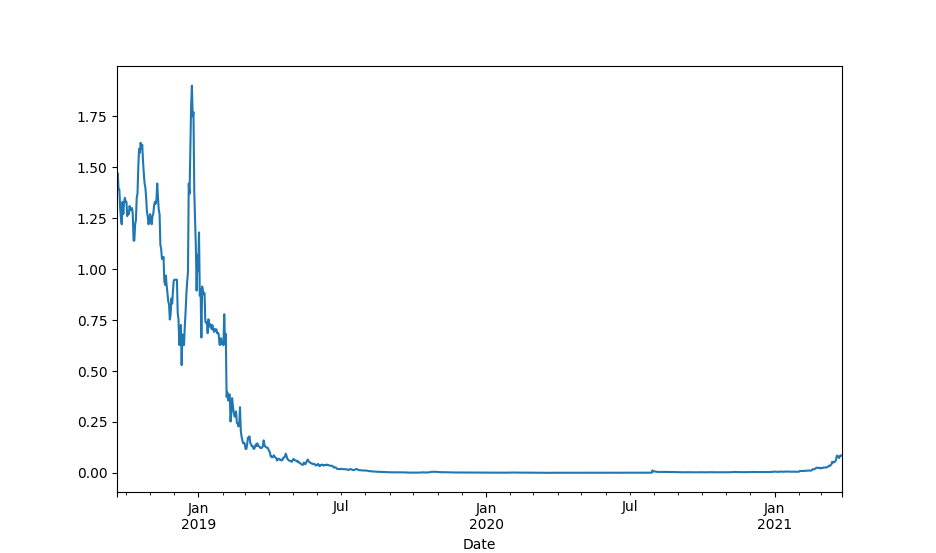

<AxesSubplot:xlabel='Date'>

In [18]:
df_spendcoin['spendcoin']['Close'].plot()